In [1]:
import numpy as np
import rasterio
from sklearn.preprocessing import MinMaxScaler


In [2]:
def read_raster(file_path):
    """Read a raster file and return the data and metadata."""
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Read the first band
        metadata = src.meta
    return data, metadata

def normalize_raster(data):
    """Normalize raster data to the range [0, 1]."""
    scaler = MinMaxScaler()
    data_flat = data.flatten().reshape(-1, 1)
    normalized_flat = scaler.fit_transform(data_flat)
    return normalized_flat.reshape(data.shape)

def ahp_weights(criteria_weights):
    """Calculate normalized AHP weights from criteria weights."""
    total = sum(criteria_weights)
    return [weight / total for weight in criteria_weights]

def topsis(data, weights):
    """Perform TOPSIS analysis."""
    norm_data = data / np.sqrt((data ** 2).sum(axis=0))
    weighted_data = norm_data * weights

    ideal_best = np.max(weighted_data, axis=0)
    ideal_worst = np.min(weighted_data, axis=0)

    distance_best = np.sqrt(((weighted_data - ideal_best) ** 2).sum(axis=1))
    distance_worst = np.sqrt(((weighted_data - ideal_worst) ** 2).sum(axis=1))

    scores = distance_worst / (distance_best + distance_worst)
    return scores

def weighted_overlay(rasters, weights):
    """Perform weighted overlay of rasters."""
    combined = np.zeros_like(rasters[0])
    for i, raster in enumerate(rasters):
        combined += raster * weights[i]
    return combined

def average_weighted(rasters):
    """Perform average weighted overlay of rasters."""
    return np.mean(rasters, axis=0)

def save_raster(output_path, data, metadata):
    """Save data to a new raster file."""
    metadata.update({"dtype": "float32"})
    with rasterio.open(output_path, "w", **metadata) as dst:
        dst.write(data, 1)


In [4]:
NDVI = r"D:\Acres\December 2024\Assignment 3\Reclassification Data\NDVI.tif"
EVI  = r"D:\Acres\December 2024\Assignment 3\Reclassification Data\NDWI.tif"
NDWI = r"D:\Acres\December 2024\Assignment 3\Reclassification Data\EVI.tif"
NIR = r"D:\Acres\December 2024\Assignment 3\Reclassification Data\NIR.tif"
RED = r"D:\Acres\December 2024\Assignment 3\Reclassification Data\GREEN.tif"
GREEN = r"D:\Acres\December 2024\Assignment 3\Reclassification Data\RED.tif"

In [5]:
# File paths to input TIFFs
file_paths = [NDVI, EVI, NDWI, NIR, GREEN, RED]



In [6]:
# Read and normalize raster data
rasters = []
metadata = None
for file_path in file_paths:
    data, metadata = read_raster(file_path)
    normalized_data = normalize_raster(data)
    rasters.append(normalized_data)

# Define criteria weights (example values, sum must equal 1)
criteria_weights = [0.2, 0.3, 0.1, 0.25, 0.15, 0.3]

# Normalize AHP weights
weights = ahp_weights(criteria_weights)

# Stack rasters into a single array for MCDM/TOPSIS analysis
stacked_rasters = np.stack(rasters, axis=2)
rows, cols, num_criteria = stacked_rasters.shape
stacked_flat = stacked_rasters.reshape(rows * cols, num_criteria)

# Perform TOPSIS analysis
scores_topsis = topsis(stacked_flat, weights)
suitability_map_topsis = scores_topsis.reshape(rows, cols)

# Perform Weighted Overlay analysis
weighted_map = weighted_overlay(rasters, weights)

# Perform Average Weighted analysis
average_weighted_map = average_weighted(rasters)



In [7]:
# Save output rasters
output_path_topsis = "D:/Acres/December 2024/Assignment 3/Results/habitat_suitability_topsis.tif"
output_path_weighted = "D:/Acres/December 2024/Assignment 3/Results/habitat_suitability_weighted_overlay.tif"
output_path_avg_weighted = "D:/Acres/December 2024/Assignment 3/Results/habitat_suitability_avg_weighted.tif"

save_raster(output_path_topsis, suitability_map_topsis, metadata)
save_raster(output_path_weighted, weighted_map, metadata)
save_raster(output_path_avg_weighted, average_weighted_map, metadata)

print(f"TOPSIS-based habitat suitability map saved to {output_path_topsis}")
print(f"Weighted overlay habitat suitability map saved to {output_path_weighted}")
print(f"Average weighted habitat suitability map saved to {output_path_avg_weighted}")

TOPSIS-based habitat suitability map saved to D:/Acres/December 2024/Assignment 3/Results/habitat_suitability_topsis.tif
Weighted overlay habitat suitability map saved to D:/Acres/December 2024/Assignment 3/Results/habitat_suitability_weighted_overlay.tif
Average weighted habitat suitability map saved to D:/Acres/December 2024/Assignment 3/Results/habitat_suitability_avg_weighted.tif


In [14]:
#AHP

In [12]:
from functools import reduce
import numpy as np
import rasterio

# Define the AHP method function
def ahp_method(dataset, wd='m'):
    inc_rat = np.array([0, 0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49, 1.51, 1.48, 1.56, 1.57, 1.59])
    X = np.copy(dataset)
    weights = np.zeros(X.shape[1])

    if wd == 'm' or wd == 'mean':
        weights = np.mean(X / np.sum(X, axis=0), axis=1)
        vector = np.sum(X * weights, axis=1) / weights
        lamb_max = np.mean(vector)
    elif wd == 'g' or wd == 'geometric':
        for i in range(X.shape[1]):
            weights[i] = reduce((lambda x, y: x * y), X[i, :])**(1 / X.shape[1])
        weights = weights / np.sum(weights)
        vector = np.sum(X * weights, axis=1) / weights
        lamb_max = np.mean(vector)
    elif wd == 'me' or wd == 'max_eigen':
        eigenvalues, eigenvectors = np.linalg.eig(X)
        eigenvalues_real = np.real(eigenvalues)
        lamb_max_index = np.argmax(eigenvalues_real)
        lamb_max = eigenvalues_real[lamb_max_index]
        principal_eigenvector = np.real(eigenvectors[:, lamb_max_index])
        weights = principal_eigenvector / principal_eigenvector.sum()

    cons_ind = (lamb_max - X.shape[1]) / (X.shape[1] - 1)
    rc = cons_ind / inc_rat[X.shape[1]]
    return weights, rc

# Define the pairwise comparison matrix
criteria_matrix = np.array([
    [1, 3, 0.5, 2, 1, 4],
    [0.33, 1, 0.25, 0.5, 0.33, 2],
    [2, 4, 1, 3, 2, 5],
    [0.5, 2, 0.33, 1, 0.5, 3],
    [1, 3, 0.5, 2, 1, 4],
    [0.25, 0.5, 0.2, 0.33, 0.25, 1]
])

# Calculate AHP weights
ahp_weights, consistency_ratio = ahp_method(criteria_matrix, wd='m')

if consistency_ratio > 0.1:
    print("Warning: Consistency ratio is too high. Revise the pairwise comparison matrix.")
else:
    print(f"AHP weights: {ahp_weights}")
    print(f"Consistency ratio: {consistency_ratio}")

# Raster file paths
NDVI = r"D:\Acres\December 2024\Assignment 3\Reclassification Data\NDVI.tif"
EVI = r"D:\Acres\December 2024\Assignment 3\Reclassification Data\EVI.tif"
NDWI = r"D:\Acres\December 2024\Assignment 3\Reclassification Data\NDWI.tif"
NIR = r"D:\Acres\December 2024\Assignment 3\Reclassification Data\NIR.tif"
RED = r"D:\Acres\December 2024\Assignment 3\Reclassification Data\RED.tif"
GREEN = r"D:\Acres\December 2024\Assignment 3\Reclassification Data\GREEN.tif"

# Reading rasters into arrays
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs

# Read each raster file
ndvi, ndvi_transform, ndvi_crs = read_raster(NDVI)
evi, _, _ = read_raster(EVI)
ndwi, _, _ = read_raster(NDWI)
nir, _, _ = read_raster(NIR)
red, _, _ = read_raster(RED)
green, _, _ = read_raster(GREEN)

# Combine rasters into a single stack
stack = np.array([ndvi, evi, ndwi, nir, red, green])

# Normalize each layer to a 0-1 range
def normalize(layer):
    return (layer - np.min(layer)) / (np.max(layer) - np.min(layer))

stack_normalized = np.array([normalize(layer) for layer in stack])

# Apply AHP weights to normalized stack
weighted_stack = np.zeros_like(stack_normalized[0])
for i, weight in enumerate(ahp_weights):
    weighted_stack += stack_normalized[i] * weight

# Save the weighted result to a new raster file
output_path = r"D:\Acres\December 2024\Assignment 3\Results\Weighted_Suitability.tif"

with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=weighted_stack.shape[0],
    width=weighted_stack.shape[1],
    count=1,
    dtype=weighted_stack.dtype,
    crs=ndvi_crs,
    transform=ndvi_transform
) as dst:
    dst.write(weighted_stack, 1)

print(f"Weighted suitability map saved to: {output_path}")


AHP weights: [0.20546767 0.07596862 0.34105314 0.12247477 0.20546767 0.04956814]
Consistency ratio: 0.010685467139109
Weighted suitability map saved to: D:\Acres\December 2024\Assignment 3\Results\Weighted_Suitability.tif


In [13]:
import tkinter as tk
from tkinter import filedialog, messagebox
import numpy as np
import rasterio
from functools import reduce
import matplotlib.pyplot as plt

# Define AHP method
def ahp_method(dataset, wd='m'):
    inc_rat = np.array([0, 0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49, 1.51, 1.48, 1.56, 1.57, 1.59])
    X = np.copy(dataset)
    weights = np.zeros(X.shape[1])

    if wd == 'm' or wd == 'mean':
        weights = np.mean(X / np.sum(X, axis=0), axis=1)
        vector = np.sum(X * weights, axis=1) / weights
        lamb_max = np.mean(vector)
    elif wd == 'g' or wd == 'geometric':
        for i in range(X.shape[1]):
            weights[i] = reduce((lambda x, y: x * y), X[i, :]) ** (1 / X.shape[1])
        weights = weights / np.sum(weights)
        vector = np.sum(X * weights, axis=1) / weights
        lamb_max = np.mean(vector)
    elif wd == 'me' or wd == 'max_eigen':
        eigenvalues, eigenvectors = np.linalg.eig(X)
        eigenvalues_real = np.real(eigenvalues)
        lamb_max_index = np.argmax(eigenvalues_real)
        lamb_max = eigenvalues_real[lamb_max_index]
        principal_eigenvector = np.real(eigenvectors[:, lamb_max_index])
        weights = principal_eigenvector / principal_eigenvector.sum()

    cons_ind = (lamb_max - X.shape[1]) / (X.shape[1] - 1)
    rc = cons_ind / inc_rat[X.shape[1]]
    return weights, rc

# GUI App
class HabitatSuitabilityApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Habitat Suitability Analysis")
        self.file_paths = []
        self.matrix = None

        # Variable input
        tk.Label(root, text="Number of Variables:").grid(row=0, column=0)
        self.num_vars = tk.IntVar()
        tk.Entry(root, textvariable=self.num_vars).grid(row=0, column=1)
        tk.Button(root, text="Generate Matrix", command=self.generate_matrix).grid(row=0, column=2)

        # File input
        self.file_inputs = []
        self.matrix_frame = None

        # Buttons for calculation
        self.calc_button = tk.Button(root, text="Calculate Habitat Suitability", command=self.calculate_suitability, state=tk.DISABLED)
        self.calc_button.grid(row=3, column=1)

        self.result_label = tk.Label(root, text="")
        self.result_label.grid(row=4, column=0, columnspan=3)

    def generate_matrix(self):
        num = self.num_vars.get()
        if num < 2:
            messagebox.showerror("Error", "Number of variables must be at least 2")
            return

        # Destroy previous matrix frame if exists
        if self.matrix_frame:
            self.matrix_frame.destroy()

        self.matrix_frame = tk.Frame(self.root)
        self.matrix_frame.grid(row=1, column=0, columnspan=3)

        tk.Label(self.matrix_frame, text="Enter Pairwise Comparison Matrix:").grid(row=0, column=0, columnspan=num)

        self.matrix_entries = []
        for i in range(num):
            row_entries = []
            for j in range(num):
                entry = tk.Entry(self.matrix_frame, width=5)
                entry.grid(row=i+1, column=j)
                row_entries.append(entry)
            self.matrix_entries.append(row_entries)

        # File upload buttons
        self.file_inputs = []
        tk.Label(self.matrix_frame, text="Upload Raster Files:").grid(row=num+2, column=0, columnspan=num)
        for i in range(num):
            tk.Button(self.matrix_frame, text=f"Upload File for Variable {i+1}", command=lambda var=i: self.upload_file(var)).grid(row=num+3+i, column=0, columnspan=num)

        self.calc_button.config(state=tk.NORMAL)

    def upload_file(self, var_index):
        file_path = filedialog.askopenfilename(filetypes=[("TIFF files", "*.tif")])
        if file_path:
            if len(self.file_inputs) <= var_index:
                self.file_inputs.append(file_path)
            else:
                self.file_inputs[var_index] = file_path

    def calculate_suitability(self):
        try:
            num = self.num_vars.get()
            self.matrix = np.zeros((num, num))
            for i in range(num):
                for j in range(num):
                    self.matrix[i, j] = float(self.matrix_entries[i][j].get())

            weights, cr = ahp_method(self.matrix, wd='m')

            if cr > 0.1:
                self.result_label.config(text=f"Consistency Ratio too high: {cr:.4f}", fg="red")
                return

            # Normalize rasters and calculate suitability
            stack = []
            for file_path in self.file_inputs:
                with rasterio.open(file_path) as src:
                    stack.append(src.read(1))
            stack = np.array(stack)

            # Normalize stack
            stack_normalized = (stack - stack.min(axis=(1, 2), keepdims=True)) / (stack.ptp(axis=(1, 2), keepdims=True))
            weighted_stack = np.sum(stack_normalized * weights[:, np.newaxis, np.newaxis], axis=0)

            # Save output
            output_path = filedialog.asksaveasfilename(defaultextension=".tif", filetypes=[("TIFF files", "*.tif")])
            if output_path:
                with rasterio.open(
                    output_path,
                    'w',
                    driver='GTiff',
                    height=weighted_stack.shape[0],
                    width=weighted_stack.shape[1],
                    count=1,
                    dtype=weighted_stack.dtype
                ) as dst:
                    dst.write(weighted_stack, 1)
                self.result_label.config(text=f"File saved successfully! CR: {cr:.4f}", fg="green")

                # Visualization
                plt.imshow(weighted_stack, cmap='viridis')
                plt.colorbar(label="Suitability Index")
                plt.title("Habitat Suitability Map")
                plt.show()
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {e}")

# Main Program
if __name__ == "__main__":
    root = tk.Tk()
    app = HabitatSuitabilityApp(root)
    root.mainloop()


C:\Users\Admin\AppData\Local\Temp\ipykernel_3740\1886287770.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  rc = cons_ind / inc_rat[X.shape[1]]


C:\Users\Admin\AppData\Local\Temp\ipykernel_3740\2962980246.py:16: RuntimeWarning: invalid value encountered in scalar divide
  rc = cons_ind / inc_rat[X.shape[1]]
C:\Users\Admin\AppData\Local\Temp\ipykernel_3740\2962980246.py:145: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(self.suitability_map, cmap="viridis")


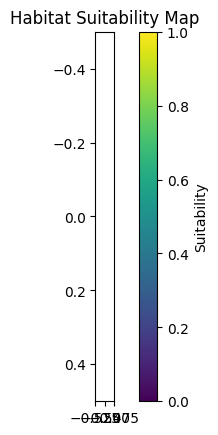

In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox
import numpy as np
import rasterio
from functools import reduce
import matplotlib.pyplot as plt


def ahp_method(dataset):
    inc_rat = np.array([0, 0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49, 1.51, 1.48, 1.56, 1.57, 1.59])
    X = np.copy(dataset)
    weights = np.mean(X / np.sum(X, axis=0), axis=1)
    vector = np.sum(X * weights, axis=1) / weights
    lamb_max = np.mean(vector)
    cons_ind = (lamb_max - X.shape[1]) / (X.shape[1] - 1)
    rc = cons_ind / inc_rat[X.shape[1]]
    return weights, rc


class AHPApp:
    def __init__(self, master):
        self.master = master
        self.master.title("AHP Habitat Suitability")
        
        self.variables = []
        self.files = {}
        
        # Add UI components
        self.add_variable_section()
        self.add_matrix_section()
        self.add_upload_section()
        self.add_compute_section()
        
    def add_variable_section(self):
        tk.Label(self.master, text="Enter Variable Names").grid(row=0, column=0, padx=10, pady=10, columnspan=2)
        self.var_entry = tk.Entry(self.master, width=30)
        self.var_entry.grid(row=1, column=0, padx=10, pady=10)
        tk.Button(self.master, text="Add Variable", command=self.add_variable).grid(row=1, column=1, padx=10, pady=10)
        
    def add_variable(self):
        variable = self.var_entry.get()
        if variable and variable not in self.variables:
            self.variables.append(variable)
            self.update_matrix()
        self.var_entry.delete(0, tk.END)
    
    def update_matrix(self):
        for widget in self.matrix_frame.winfo_children():
            widget.destroy()
        
        size = len(self.variables)
        self.matrix_entries = [[tk.Entry(self.matrix_frame, width=10) for _ in range(size)] for _ in range(size)]
        
        for i, var in enumerate(self.variables):
            tk.Label(self.matrix_frame, text=var).grid(row=i + 1, column=0)
            tk.Label(self.matrix_frame, text=var).grid(row=0, column=i + 1)
            for j in range(size):
                entry = self.matrix_entries[i][j]
                entry.grid(row=i + 1, column=j + 1)
                if i == j:
                    entry.insert(0, "1")
                    entry.config(state="disabled")
                    
        self.matrix_frame.update_idletasks()
    
    def add_matrix_section(self):
        tk.Label(self.master, text="Pairwise Comparison Matrix").grid(row=2, column=0, padx=10, pady=10, columnspan=2)
        self.matrix_frame = tk.Frame(self.master)
        self.matrix_frame.grid(row=3, column=0, columnspan=2, padx=10, pady=10)
    
    def add_upload_section(self):
        tk.Label(self.master, text="Upload Raster Files for Variables").grid(row=4, column=0, padx=10, pady=10, columnspan=2)
        self.upload_frame = tk.Frame(self.master)
        self.upload_frame.grid(row=5, column=0, columnspan=2, padx=10, pady=10)
        
        self.upload_buttons = []
        for var in self.variables:
            btn = tk.Button(self.upload_frame, text=f"Upload {var}", command=lambda v=var: self.upload_file(v))
            btn.pack(padx=5, pady=5)
            self.upload_buttons.append(btn)
    
    def upload_file(self, variable):
        file_path = filedialog.askopenfilename(filetypes=[("TIFF files", "*.tif")])
        if file_path:
            self.files[variable] = file_path
            messagebox.showinfo("File Uploaded", f"{variable} file uploaded successfully.")
    
    def add_compute_section(self):
        self.compute_button = tk.Button(self.master, text="Compute Habitat Suitability", command=self.compute)
        self.compute_button.grid(row=6, column=0, padx=10, pady=10)
        self.save_button = tk.Button(self.master, text="Save & Visualize", state="disabled", command=self.save_and_visualize)
        self.save_button.grid(row=6, column=1, padx=10, pady=10)
    
    def compute(self):
        size = len(self.variables)
        matrix = np.zeros((size, size))
        try:
            for i in range(size):
                for j in range(size):
                    if i == j:
                        matrix[i][j] = 1
                    else:
                        value = float(self.matrix_entries[i][j].get())
                        matrix[i][j] = value
                        matrix[j][i] = 1 / value
            
            weights, cr = ahp_method(matrix)
            if cr > 0.1:
                messagebox.showwarning("Consistency Issue", f"Consistency ratio too high: {cr:.3f}. Revise the matrix.")
            else:
                self.weights = weights
                self.compute_habitat_suitability()
                self.save_button.config(state="normal")
                messagebox.showinfo("Success", f"Habitat suitability computed. Consistency ratio: {cr:.3f}.")
        except Exception as e:
            messagebox.showerror("Error", f"Error in computation: {e}")
    
    def compute_habitat_suitability(self):
        # Read rasters and compute weighted sum
        stack = []
        for var in self.variables:
            file_path = self.files.get(var)
            if file_path:
                with rasterio.open(file_path) as src:
                    stack.append(src.read(1))
        stack = np.array(stack)
        normalized_stack = np.array([(layer - np.min(layer)) / (np.max(layer) - np.min(layer)) for layer in stack])
        self.suitability_map = np.sum(normalized_stack * self.weights[:, np.newaxis, np.newaxis], axis=0)
    
    def save_and_visualize(self):
        output_path = filedialog.asksaveasfilename(defaultextension=".tif", filetypes=[("TIFF files", "*.tif")])
        if output_path:
            with rasterio.open(
                output_path,
                "w",
                driver="GTiff",
                height=self.suitability_map.shape[0],
                width=self.suitability_map.shape[1],
                count=1,
                dtype=self.suitability_map.dtype
            ) as dst:
                dst.write(self.suitability_map, 1)
            messagebox.showinfo("Saved", f"File saved to {output_path}.")
        
        plt.imshow(self.suitability_map, cmap="viridis")
        plt.colorbar(label="Suitability")
        plt.title("Habitat Suitability Map")
        plt.show()


# Run the GUI
root = tk.Tk()
app = AHPApp(root)
root.mainloop()


In [10]:
import tkinter as tk
from tkinter import filedialog, messagebox
import numpy as np
import rasterio
import matplotlib.pyplot as plt


def ahp_method(dataset):
    inc_rat = np.array([0, 0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49, 1.51, 1.48, 1.56, 1.57, 1.59])
    size = dataset.shape[1]
    weights = np.mean(dataset / np.sum(dataset, axis=0), axis=1)
    vector = np.sum(dataset * weights, axis=1) / weights
    lamb_max = np.mean(vector)
    ci = (lamb_max - size) / (size - 1)
    cr = ci / inc_rat[size]
    return weights, ci, cr


class AHPApp:
    def __init__(self, master):
        self.master = master
        self.master.title("AHP Habitat Suitability")

        self.variables = []
        self.files = {}
        
        self.weights = None
        self.cr = None
        self.ci = None

        # Add UI components
        self.add_variable_section()
        self.add_matrix_section()
        self.add_calculate_section()
        self.add_upload_section()

    def add_variable_section(self):
        tk.Label(self.master, text="Enter Variable Names").grid(row=0, column=0, padx=10, pady=10, columnspan=2)
        self.var_entry = tk.Entry(self.master, width=30)
        self.var_entry.grid(row=1, column=0, padx=10, pady=10)
        tk.Button(self.master, text="Add Variable", command=self.add_variable).grid(row=1, column=1, padx=10, pady=10)

    def add_variable(self):
        variable = self.var_entry.get()
        if variable and variable not in self.variables:
            self.variables.append(variable)
            self.update_matrix()
        self.var_entry.delete(0, tk.END)

    def update_matrix(self):
        for widget in self.matrix_frame.winfo_children():
            widget.destroy()

        size = len(self.variables)
        self.matrix_entries = [[tk.Entry(self.matrix_frame, width=10) for _ in range(size)] for _ in range(size)]

        for i, var in enumerate(self.variables):
            tk.Label(self.matrix_frame, text=var).grid(row=i + 1, column=0)
            tk.Label(self.matrix_frame, text=var).grid(row=0, column=i + 1)
            for j in range(size):
                entry = self.matrix_entries[i][j]
                entry.grid(row=i + 1, column=j + 1)
                if i == j:
                    entry.insert(0, "1")
                    entry.config(state="disabled")

        self.matrix_frame.update_idletasks()

    def add_matrix_section(self):
        tk.Label(self.master, text="Pairwise Comparison Matrix").grid(row=2, column=0, padx=10, pady=10, columnspan=2)
        self.matrix_frame = tk.Frame(self.master)
        self.matrix_frame.grid(row=3, column=0, columnspan=2, padx=10, pady=10)

    def add_calculate_section(self):
        self.calculate_button = tk.Button(self.master, text="Calculate CR & CI", command=self.calculate_cr_ci)
        self.calculate_button.grid(row=4, column=0, padx=10, pady=10)

        self.result_label = tk.Label(self.master, text="")
        self.result_label.grid(row=4, column=1, padx=10, pady=10)

    def calculate_cr_ci(self):
        size = len(self.variables)
        matrix = np.zeros((size, size))
        try:
            for i in range(size):
                for j in range(size):
                    if i == j:
                        matrix[i][j] = 1
                    else:
                        value = float(self.matrix_entries[i][j].get())
                        matrix[i][j] = value
                        matrix[j][i] = 1 / value

            self.weights, self.ci, self.cr = ahp_method(matrix)

            if self.cr > 0.1:
                messagebox.showwarning("Consistency Issue", f"Consistency ratio too high: {self.cr:.3f}. Revise the matrix.")
            else:
                self.result_label.config(text=f"CI: {self.ci:.3f}, CR: {self.cr:.3f}")
                self.create_upload_buttons()

        except Exception as e:
            messagebox.showerror("Error", f"Error in computation: {e}")

    def add_upload_section(self):
        self.upload_frame = tk.Frame(self.master)
        self.upload_frame.grid(row=5, column=0, columnspan=2, padx=10, pady=10)

    def create_upload_buttons(self):
        for widget in self.upload_frame.winfo_children():
            widget.destroy()

        for var in self.variables:
            tk.Label(self.upload_frame, text=f"Upload raster for {var}:").pack(pady=5)
            btn = tk.Button(self.upload_frame, text=f"Browse", command=lambda v=var: self.upload_file(v))
            btn.pack(padx=5, pady=5)

        tk.Button(self.master, text="Compute Suitability Map", command=self.compute_habitat_suitability).grid(row=6, column=0, padx=10, pady=10)

    def upload_file(self, variable):
        file_path = filedialog.askopenfilename(filetypes=[("TIFF files", "*.tif")])
        if file_path:
            self.files[variable] = file_path
            messagebox.showinfo("File Uploaded", f"{variable} file uploaded successfully.")

    def compute_habitat_suitability(self):
        if not all(var in self.files for var in self.variables):
            messagebox.showerror("Missing Files", "Please upload raster files for all variables.")
            return

        stack = []
        for var in self.variables:
            file_path = self.files[var]
            with rasterio.open(file_path) as src:
                stack.append(src.read(1))

        stack = np.array(stack)
        normalized_stack = np.array([(layer - np.min(layer)) / (np.max(layer) - np.min(layer)) for layer in stack])
        suitability_map = np.sum(normalized_stack * self.weights[:, np.newaxis, np.newaxis], axis=0)

        plt.imshow(suitability_map, cmap="viridis")
        plt.colorbar(label="Suitability")
        plt.title("Habitat Suitability Map")
        plt.show()


# Run the GUI
root = tk.Tk()
app = AHPApp(root)
root.mainloop()


C:\Users\Admin\AppData\Local\Temp\ipykernel_3740\2996016767.py:15: RuntimeWarning: invalid value encountered in scalar divide
  cr = ci / inc_rat[size]


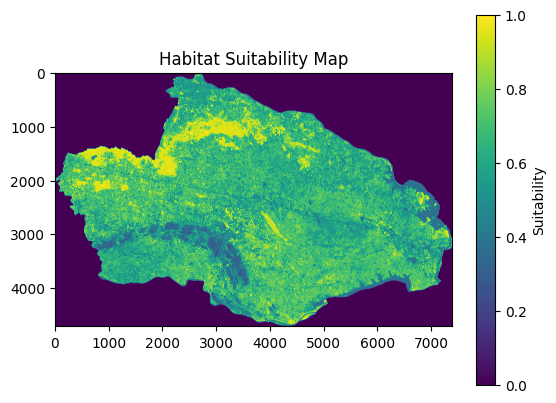

In [19]:
import tkinter as tk
from tkinter import filedialog, messagebox
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt


def ahp_method(dataset):
    inc_rat = np.array([0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49, 1.51, 1.48, 1.56, 1.57, 1.59])
    size = dataset.shape[0]
    weights = np.mean(dataset / np.sum(dataset, axis=0), axis=1)
    vector = np.sum(dataset * weights, axis=1)
    lamb_max = np.mean(vector / weights)
    ci = (lamb_max - size) / (size - 1) if size > 1 else 0
    cr = ci / inc_rat[size - 1] if size > 1 else 0
    return weights, ci, cr



class AHPApp:
    def __init__(self, master):
        self.master = master
        self.master.title("AHP Habitat Suitability")

        self.variables = []
        self.files = {}
        
        self.weights = None
        self.cr = None
        self.ci = None

        self.add_variable_section()
        self.add_matrix_section()
        self.add_calculate_section()
        self.add_upload_section()

    def add_variable_section(self):
        tk.Label(self.master, text="Enter Variable Names").grid(row=0, column=0, padx=10, pady=10, columnspan=2)
        self.var_entry = tk.Entry(self.master, width=30)
        self.var_entry.grid(row=1, column=0, padx=10, pady=10)
        tk.Button(self.master, text="Add Variable", command=self.add_variable).grid(row=1, column=1, padx=10, pady=10)

    def add_variable(self):
        variable = self.var_entry.get()
        if variable and variable not in self.variables:
            self.variables.append(variable)
            self.update_matrix()
        self.var_entry.delete(0, tk.END)

    def update_matrix(self):
        for widget in self.matrix_frame.winfo_children():
            widget.destroy()

        size = len(self.variables)
        self.matrix_entries = [[tk.Entry(self.matrix_frame, width=10) for _ in range(size)] for _ in range(size)]

        for i, var in enumerate(self.variables):
            tk.Label(self.matrix_frame, text=var).grid(row=i + 1, column=0)
            tk.Label(self.matrix_frame, text=var).grid(row=0, column=i + 1)
            for j in range(size):
                entry = self.matrix_entries[i][j]
                entry.grid(row=i + 1, column=j + 1)
                if i == j:
                    entry.insert(0, "1")
                    entry.config(state="disabled")

        self.matrix_frame.update_idletasks()

    def add_matrix_section(self):
        tk.Label(self.master, text="Pairwise Comparison Matrix").grid(row=2, column=0, padx=10, pady=10, columnspan=2)
        self.matrix_frame = tk.Frame(self.master)
        self.matrix_frame.grid(row=3, column=0, columnspan=2, padx=10, pady=10)

    def add_calculate_section(self):
        self.calculate_button = tk.Button(self.master, text="Calculate CR & CI", command=self.calculate_cr_ci)
        self.calculate_button.grid(row=4, column=0, padx=10, pady=10)

        self.result_label = tk.Label(self.master, text="")
        self.result_label.grid(row=4, column=1, padx=10, pady=10)

    def calculate_cr_ci(self):
        size = len(self.variables)
        matrix = np.zeros((size, size))
        try:
            for i in range(size):
                for j in range(size):
                    if i == j:
                        matrix[i][j] = 1
                    else:
                        value = float(self.matrix_entries[i][j].get())
                        matrix[i][j] = value
                        matrix[j][i] = 1 / value

            self.weights, self.ci, self.cr = ahp_method(matrix)

            if self.cr > 0.1:
                messagebox.showwarning("Consistency Issue", f"Consistency ratio too high: {self.cr:.3f}. Revise the matrix.")
            else:
                self.result_label.config(text=f"CI: {self.ci:.3f}, CR: {self.cr:.3f}")
                self.create_upload_buttons()

        except Exception as e:
            messagebox.showerror("Error", f"Error in computation: {e}")

    def add_upload_section(self):
        self.upload_frame = tk.Frame(self.master)
        self.upload_frame.grid(row=5, column=0, columnspan=2, padx=10, pady=10)

    def create_upload_buttons(self):
        for widget in self.upload_frame.winfo_children():
            widget.destroy()

        for var in self.variables:
            tk.Label(self.upload_frame, text=f"Upload raster for {var}:").pack(pady=5)
            frame = tk.Frame(self.upload_frame)
            frame.pack(pady=5)
            
            # Button for browsing the file
            btn = tk.Button(frame, text="Browse", command=lambda v=var: self.upload_file(v))
            btn.pack(side=tk.LEFT, padx=5)
            
            # Label for showing the uploaded file name
            tk.Label(frame, text=f"").pack(side=tk.LEFT)
            
        tk.Button(self.master, text="Compute Suitability Map", command=self.compute_habitat_suitability).grid(row=6, column=0, padx=10, pady=10)


    def upload_file(self, variable):
        file_path = filedialog.askopenfilename(filetypes=[("TIFF files", "*.tif")])
        if file_path:
            self.files[variable] = file_path
            # Update the button label to show the file name
            for child in self.upload_frame.winfo_children():
                if isinstance(child, tk.Label) and child.cget("text").startswith(f"Upload raster for {variable}:"):
                    child.config(text=f"{variable} file uploaded: {file_path}")
            messagebox.showinfo("File Uploaded", f"{variable} file uploaded successfully.")


    def compute_habitat_suitability(self):
        if not all(var in self.files for var in self.variables):
            messagebox.showerror("Missing Files", "Please upload raster files for all variables.")
            return

        stack = []
        profile = None
        for var in self.variables:
            file_path = self.files[var]
            with rasterio.open(file_path) as src:
                stack.append(src.read(1))
                if profile is None:
                    profile = src.profile

        stack = np.array(stack)
        normalized_stack = np.array([(layer - np.min(layer)) / (np.max(layer) - np.min(layer)) for layer in stack])
        suitability_map = np.sum(normalized_stack * self.weights[:, np.newaxis, np.newaxis], axis=0)

        plt.imshow(suitability_map, cmap="viridis")
        plt.colorbar(label="Suitability")
        plt.title("Habitat Suitability Map")
        plt.show()

        # Save suitability map as TIFF
        def save_tiff():
            save_path = filedialog.asksaveasfilename(defaultextension=".tif", filetypes=[("TIFF files", "*.tif")])
            if save_path:
                profile.update(dtype=rasterio.float32, count=1)
                with rasterio.open(save_path, 'w', **profile) as dst:
                    dst.write(suitability_map.astype(np.float32), 1)
                messagebox.showinfo("Saved", "Suitability map saved successfully.")

        tk.Button(self.master, text="Save Suitability Map as TIFF", command=save_tiff).grid(row=7, column=0, padx=10, pady=10)


# Run the GUI
root = tk.Tk()
app = AHPApp(root)
root.mainloop()
